# Import package

In [1]:
import os
import torch
import pandas as pd
import numpy as np
import pytorch_lightning as pl
from pytorch_lightning import loggers
from pytorch_lightning.callbacks import ModelCheckpoint

In [2]:
%load_ext autoreload
%autoreload 2

# Setup environment

In [3]:
device = "cuda" if torch.cuda.is_available else "cpu"

def format_bytes(size):
    # 2**10 = 1024
    power = 2**10
    n = 0
    power_labels = {0 : '', 1: 'kilo', 2: 'mega', 3: 'giga', 4: 'tera'}
    while size > power:
        size /= power
        n += 1
    return "%.2f" % size, power_labels[n] + 'bytes'

torch.cuda.get_device_name(), format_bytes(torch.cuda.get_device_properties(device).total_memory)

('GeForce GTX 1080 Ti', ('10.92', 'gigabytes'))

# Load model

In [4]:
from trainer.supervised.baseline import BaselineTrainer
model = BaselineTrainer()
max_epoches = model.get_max_epoches()

>> Load from data frame


Using cache found in /home/kientiet/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master




>> Running with 1cycle scheduler


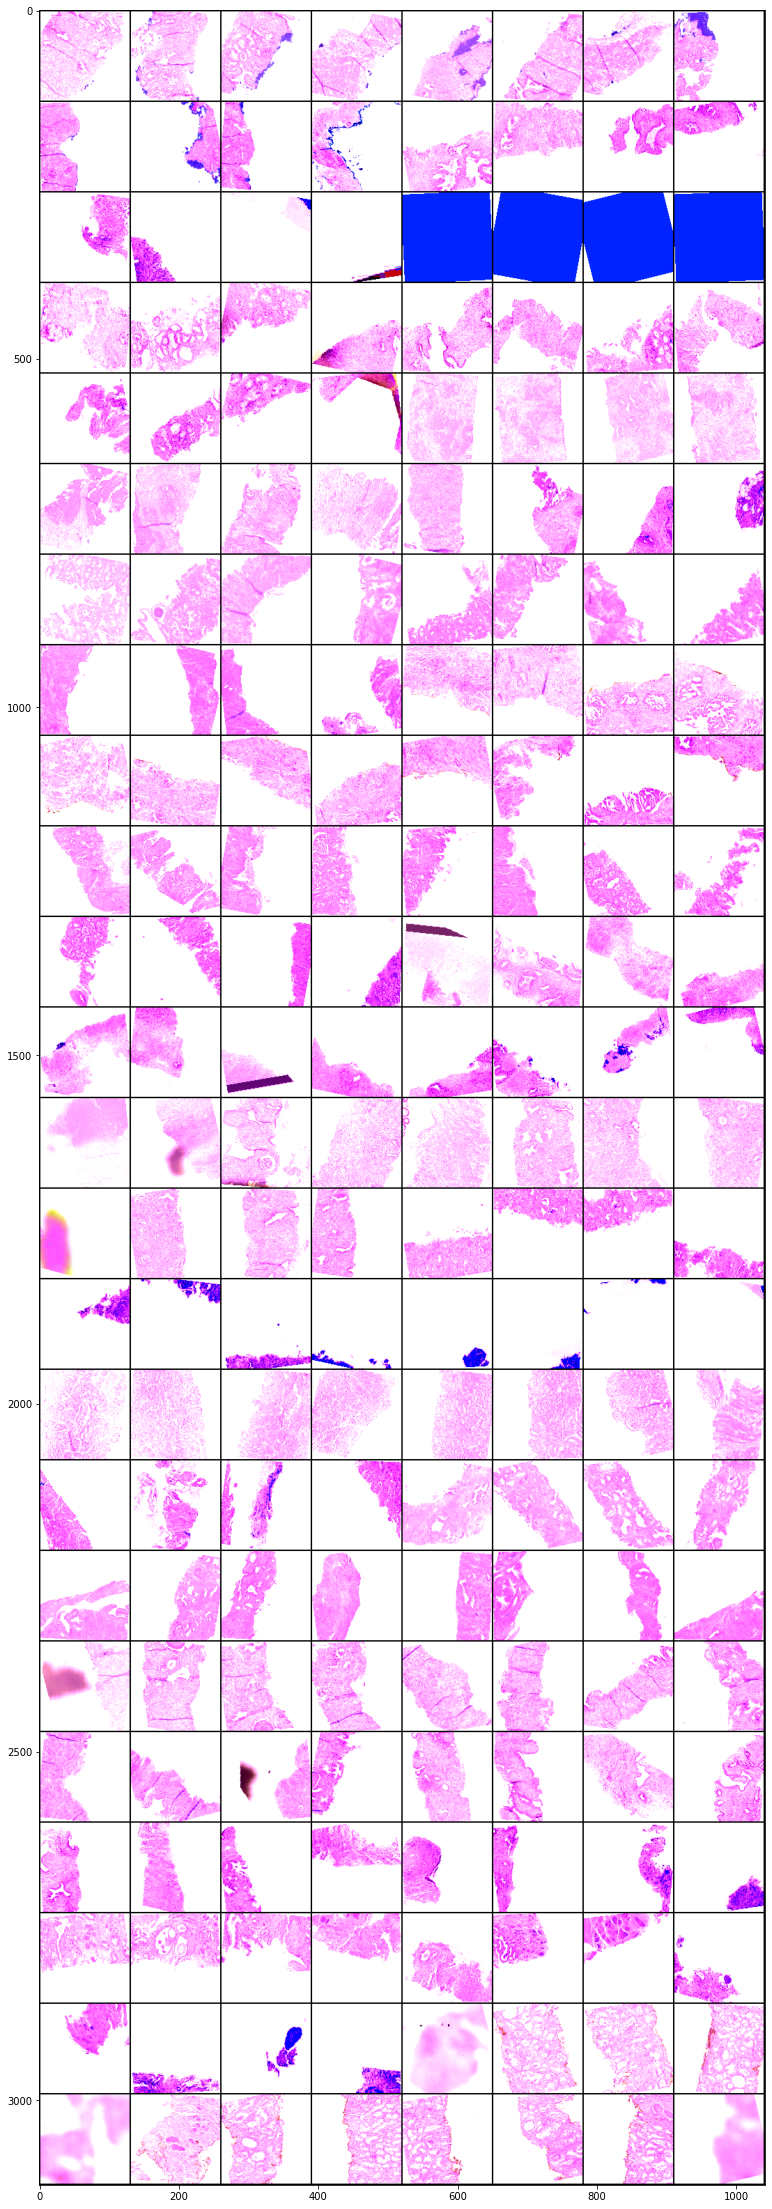

In [5]:
import torchvision
import matplotlib.pyplot as plt
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
plt.figure(figsize=(20,40))
images, labels = next(iter(model.trainloader))
images = images.reshape(-1, 3, 128, 128)
# show images
imshow(torchvision.utils.make_grid(images))

In [6]:
checkpoint_path = os.path.join(os.getcwd(), "checkpoint", model.model_name)
checkpoint_callback = ModelCheckpoint(
    filepath = checkpoint_path,
    save_top_k = 5,
    verbose = True,
    monitor = 'kappa_score/kappa_score',
    mode = 'max'
)

checkpoint_path

/home/kientiet/.local/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: Checkpoint directory /home/kientiet/Documents/My Project/python/panda-kaggle/checkpoint/baseline/resnet50_32x4d exists and is not empty with save_top_k != 0.All files in this directory will be deleted when a checkpoint is saved!
  warnings.warn(*args, **kwargs)


'/home/kientiet/Documents/My Project/python/panda-kaggle/checkpoint/baseline/resnet50_32x4d'

In [7]:
tb_logger = loggers.TensorBoardLogger('logs/', name = model.model_name)
trainer = pl.Trainer(checkpoint_callback = checkpoint_callback,
                    nb_sanity_val_steps = 0, 
                    max_epochs = max_epoches, 
                    gpus = -1, 
                    logger = tb_logger)

INFO:lightning:GPU available: True, used: True
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]


# Learning finder

In [8]:
# lr_finder = trainer.lr_find(model, min_lr = 1e-8, max_lr = 5., num_training = 200)

In [9]:
# fig = lr_finder.plot(suggest = True)

In [10]:
model.configure_optimizers()



>> Running with 1cycle scheduler


Lookahead (
Parameter Group 0
    betas: (0.9, 0.999)
    eps: 1e-08
    initial_lr: 0.0005
    lr: 0.0004999997256657939
    max_lr: 0.0005
    min_lr: 5e-06
    step_counter: 0
    weight_decay: 5e-05
)

## Start to train

In [11]:
trainer.fit(model)

INFO:lightning:
    | Name                             | Type              | Params
-------------------------------------------------------------------
0   | loss_func                        | CrossEntropyLoss  | 0     
1   | encoder                          | ResNetModel       | 22 M  
2   | encoder.encoder                  | Sequential        | 22 M  
3   | encoder.encoder.0                | Conv2d            | 9 K   
4   | encoder.encoder.1                | BatchNorm2d       | 128   
5   | encoder.encoder.2                | ReLU              | 0     
6   | encoder.encoder.3                | MaxPool2d         | 0     
7   | encoder.encoder.4                | Sequential        | 205 K 
8   | encoder.encoder.4.0              | Bottleneck        | 63 K  
9   | encoder.encoder.4.0.conv1        | Conv2d            | 8 K   
10  | encoder.encoder.4.0.bn1          | BatchNorm2d       | 256   
11  | encoder.encoder.4.0.conv2        | Conv2d            | 4 K   
12  | encoder.encoder.4.0.bn2   



>> Running with 1cycle scheduler
>> Return trainloader
>> Return valloader


/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha)


INFO:lightning:
Epoch 00000: kappa_score/kappa_score reached 0.59532 (best 0.59532), saving model to /home/kientiet/Documents/My Project/python/panda-kaggle/checkpoint/baseline/resnet50_32x4d/epoch=0.ckpt as top 5


INFO:lightning:
Epoch 00001: kappa_score/kappa_score reached 0.69622 (best 0.69622), saving model to /home/kientiet/Documents/My Project/python/panda-kaggle/checkpoint/baseline/resnet50_32x4d/epoch=1.ckpt as top 5


INFO:lightning:
Epoch 00002: kappa_score/kappa_score reached 0.66577 (best 0.69622), saving model to /home/kientiet/Documents/My Project/python/panda-kaggle/checkpoint/baseline/resnet50_32x4d/epoch=2.ckpt as top 5


INFO:lightning:
Epoch 00003: kappa_score/kappa_score reached 0.68612 (best 0.69622), saving model to /home/kientiet/Documents/My Project/python/panda-kaggle/checkpoint/baseline/resnet50_32x4d/epoch=3.ckpt as top 5


INFO:lightning:
Epoch 00004: kappa_score/kappa_score reached 0.68372 (best 0.69622), saving model to /home/kientiet/Documents/My Project/python/panda-kaggle/checkpoint/baseline/resnet50_32x4d/epoch=4.ckpt as top 5




>> Running with 1cycle scheduler


INFO:lightning:
Epoch 00005: kappa_score/kappa_score reached 0.69641 (best 0.69641), saving model to /home/kientiet/Documents/My Project/python/panda-kaggle/checkpoint/baseline/resnet50_32x4d/epoch=5.ckpt as top 5


INFO:lightning:
Epoch 00006: kappa_score/kappa_score reached 0.70657 (best 0.70657), saving model to /home/kientiet/Documents/My Project/python/panda-kaggle/checkpoint/baseline/resnet50_32x4d/epoch=6.ckpt as top 5


INFO:lightning:
Epoch 00007: kappa_score/kappa_score  was not in top 5


INFO:lightning:
Epoch 00008: kappa_score/kappa_score reached 0.69915 (best 0.70657), saving model to /home/kientiet/Documents/My Project/python/panda-kaggle/checkpoint/baseline/resnet50_32x4d/epoch=8.ckpt as top 5


INFO:lightning:
Epoch 00009: kappa_score/kappa_score reached 0.72846 (best 0.72846), saving model to /home/kientiet/Documents/My Project/python/panda-kaggle/checkpoint/baseline/resnet50_32x4d/epoch=9.ckpt as top 5




>> Running with 1cycle scheduler


INFO:lightning:
Epoch 00010: kappa_score/kappa_score  was not in top 5


INFO:lightning:
Epoch 00011: kappa_score/kappa_score reached 0.73883 (best 0.73883), saving model to /home/kientiet/Documents/My Project/python/panda-kaggle/checkpoint/baseline/resnet50_32x4d/epoch=11.ckpt as top 5


INFO:lightning:
Epoch 00012: kappa_score/kappa_score reached 0.71145 (best 0.73883), saving model to /home/kientiet/Documents/My Project/python/panda-kaggle/checkpoint/baseline/resnet50_32x4d/epoch=12.ckpt as top 5


INFO:lightning:
Epoch 00013: kappa_score/kappa_score reached 0.76925 (best 0.76925), saving model to /home/kientiet/Documents/My Project/python/panda-kaggle/checkpoint/baseline/resnet50_32x4d/epoch=13.ckpt as top 5


INFO:lightning:
Epoch 00014: kappa_score/kappa_score reached 0.74740 (best 0.76925), saving model to /home/kientiet/Documents/My Project/python/panda-kaggle/checkpoint/baseline/resnet50_32x4d/epoch=14.ckpt as top 5


1